In [1]:
import netCDF4
import glob
import os
import numpy as np
import pandas as pd
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

# Collect data from the netCDF file

In [ ]:
# This database contains prate from 1806-2015 (inclusive)
# We are collecting data from this entire period
MIN_YEAR = 1806
MAX_YEAR = 2015

MIN_LAT = -60
MAX_LAT = 30
MIN_LON = 13
MAX_LON = 120

In [ ]:
file = "prate.mon.mean.nc"
f = netCDF4.Dataset(file)

In [ ]:
# get all the variables
print(f.variables.keys())

In [ ]:
# print the information of all variables
all_vars = []
lat = f.variables['lat'] 
all_vars.append(lat)
lon = f.variables['lon']
all_vars.append(lon)
time_bnds = f.variables['time_bnds'] 
all_vars.append(time_bnds)
time = f.variables['time'] 
all_vars.append(time)
prate = f.variables['prate']
all_vars.append(prate)

for var in all_vars:
    print(var)
    print()

In [ ]:
# obtain lists of years, lat, and lon

years = list(range(MIN_YEAR, MAX_YEAR+1))

list_lat = list(lat)
list_lon = list(lon)
lat_indices = [i for i in range(len(list_lat)) if list_lat[i] >= MIN_LAT and list_lat[i] <= MAX_LAT] 
lon_indices = [i for i in range(len(list_lon)) if list_lon[i] >= MIN_LON and list_lon[i] <= MAX_LON]

In [ ]:
# this is monthly data over the span 1806-2015
# so there should be 12 * (2015-1806+1) time values
print(len(time) == (12 * (2015-1806+1)))

# print the first 10 values of time
for i in range(10):
    print(time[i])

In [ ]:
# print the latitudes and the indices of those latitudes that we need
for lat_ind in lat_indices:
    print(lat_ind, lat[lat_ind])

In [ ]:
# print the longitudes and the indices of those longitudes that we need
for lon_ind in lon_indices:
    print(lon_ind, lon[lon_ind])

In [ ]:
# the columns for the csv file we will output
columns = "Date,Latitude,Longitude,mon_mean_prate\n"

In [ ]:
# Let's collect data year by year as a check point so if the program crashes
# we don't have to restart entirely

# yearly data path
yearly_data_dir = "/Users/Sienna/Desktop/yearly_data_prate/"
os.makedirs(yearly_data_dir, exist_ok=True)

In [ ]:
# iterate through year -> lat -> lon
start_time_index = 0

for year in years:
    
    file_name = yearly_data_dir + str(year) + ".csv"
    f_cur = open(file_name, "w")
    f_cur.write(columns)
    
    for month_i in range(12):
        date = f'{str(year)}-{"{:02d}".format(month_i+1)}-01'
        
        for lat_i in lat_indices:
            for lon_i in lon_indices:
                
                pr = prate[start_time_index+month_i][lat_i][lon_i]
                to_write = date + "," + str(lat[lat_i]) + "," + str(lon[lon_i]) + "," + str(pr) + "\n"
                f_cur.write(to_write)
    
    start_time_index += 12
    f_cur.close()

In [ ]:
f.close()

In [ ]:
# Now we combine all yearly data into a single csv, stored in the path below
raw_data_path = "/Users/Sienna/Desktop/rean_v3_prate_wide_1806_2015.csv"

In [ ]:
f_final = open(raw_data_path, "w")
f_final.write(columns)

filelist = glob.glob(os.path.join(yearly_data_dir, '*.csv'))
for infile in sorted(filelist): 
    f = open(infile, "r")
    lines = f.readlines()
    for line in lines[1:]:
        f_final.write(line)
    f.close()

f_final.close()

# Manipulate the data

Here we convert the monthly mean prate into annual mean prate with a year defined as June to May. We also calculate the average annual mean prate over 1806-2015. Then we calculate the anomaly with (annual mean prate / average annual mean prate * 100).

Before we do anything, we convert the prate unit into mm/day by multiplying the original prate with 86400.

In [ ]:
# Process the raw data we collected in the first part of this notebook
df_original = pd.read_csv(raw_data_path)
df_original['mon_mean_prate'] = df_original['mon_mean_prate'] * 86400

In [ ]:
# Create a new dataframe for annual data
column_names = ['Date', 'Latitude', 'Longitude', 'annual_prate', 'avg_annual_prate', 'anomaly (%)']
df_annual = pd.DataFrame(columns=column_names)

In [ ]:
# Generate all pairs of our target latitudes and longitudes
targets = []
for target_lat in range(MIN_LAT, MAX_LAT+1):
    for target_lon in range(MIN_LON, MAX_LON+1):
        targets.append((target_lat, target_lon))

In [ ]:
# We iterate through each target coordination pair to calculate that location's
# annual data
for target in targets:
    target_lat = target[0]
    target_lon = target[1]
    
    # create a dataframe for this location
    df_target = df_original[(df_original['Latitude'] == target_lat) \
                        & (df_original['Longitude'] == target_lon)]

    # clip the first 5 months of 1806 and the last 7 months of 2015 off
    df_target = df_target.iloc[5:-7]
    
    # start calculating the annual data
    annual_sum = 0
    date = ""
    annual_prates = []
    new_row_dicts = []

    for index, row in df_target.iterrows():

        # June, the start of the year
        if row["Date"][5:7] == "06":
            annual_sum = row["mon_mean_prate"]
            date = row["Date"]

        # May, the end of the year
        elif row["Date"][5:7] == "05":
            annual_sum += row["mon_mean_prate"]
            annual_prate = annual_sum / 12 
            annual_prates.append(annual_prate)

            new_row = {"Date": date, "Latitude": row["Latitude"], "Longitude": row["Longitude"], \
                      "annual_prate": annual_prate, "avg_annual_prate": 0, "anomaly (%)": 0}   # 0 is placeholder

            new_row_dicts.append(new_row)

        # Rest of the year
        else:
            annual_sum += row["mon_mean_prate"]

    avg_annual_prate = np.mean(annual_prates)

    # fill in avg_annual_prate and calculate anomaly, append the row to the df_annual
    for new_row in new_row_dicts:
        new_row["avg_annual_prate"] = avg_annual_prate
        new_row["anomaly (%)"] = new_row["annual_prate"] / avg_annual_prate * 100
        df_annual = df_annual.append(new_row, ignore_index=True)

In [ ]:
csv_file_path = '/Users/Sienna/Desktop/rean_v3_prate_wide_annual_1806_2015.csv'
df_annual.to_csv(csv_file_path, index=False)

In [ ]:
df_annual.head(20)

# Plot time-series
A time series plot for each target climate zone.

In [2]:
min_lat = -90
max_lat = 90
min_lon = 0
max_lon = 360

# generate all possible coords
coords = []
for lon in range(min_lon, max_lon+1):
    for lat in range(min_lat, max_lat+1):
        coords.append((lon, lat))  

In [3]:
# Ray-casting algorithm to check if a point is in a polygon
def is_point_on_line_segment(point: Tuple[float, float], line_start: Tuple[float, float], line_end: Tuple[float, float]) -> bool:
    """Check if a point is on a line segment defined by two points."""
    px, py = point
    sx, sy = line_start
    ex, ey = line_end

    # Check if point is within the bounding box of the line segment
    if min(sx, ex) <= px <= max(sx, ex) and min(sy, ey) <= py <= max(sy, ey):
        # Check if the cross product of (point - start) and (end - start) is zero
        if (px - sx) * (ey - sy) == (py - sy) * (ex - sx):
            return True
    return False

def is_point_in_polygon(point: Tuple[float, float], polygon: List[Tuple[float, float]]) -> bool:
    """Check if a point is inside a polygon or on its boundary."""
    x, y = point
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        
        # Check if the point is on the boundary
        if is_point_on_line_segment(point, (p1x, p1y), (p2x, p2y)):
            return True
        
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside

# Function to categorize coordinates into climate zones
def categorize_coordinates(coords: List[Tuple[float, float]], zones: dict) -> List[str]:
    categories = []
    for coord in coords:
        categorized = False
        for zone_num, zone_polygon in zones.items():
            if is_point_in_polygon(coord, zone_polygon):
                categories.append(zone_num)
                categorized = True
                break
        if not categorized:
            categories.append(-1)
    return categories

In [4]:
target_zones = {
    
    1: [(80, 8), (87, 19), (93, 19), (93, 8)],
    
    2: [(80, -9), (80, 7), (93, 7), (93, -9)],
    
    3.1: [(32, -35), (33, -34), (33, -33), (35, -31), (35, -30), (36, -29), (37, -28), (44, -28), 
          (45, -27), (47, -27), (48, -26), (50, -26), (52, -24), (54, -24), (55, -23), (60, -23),
          (60, -22), (63, -22), (63, -21), (66, -21), (66, -20), (70, -20), (70, -18), (73, -18), 
          (73, -17), (75, -17), (75, -15), (77, -15), (77, -14), (78, -14), (78, -12), (79, -12), 
          (79, -10), (105, -10), (105, -15), (99, -15), (99, -16), (93, -16), (93, -17), (92, -17), 
          (92, -18), (91, -19), (89, -19), (89, -20), (86, -20), (86, -21), (84, -21), (84, -22), 
          (82, -22), (82, -23), (75, -23), (75, -24), (72, -24), (72, -25), (67, -25), (67, -26), 
          (64, -26), (64, -27), (60, -27), (60, -28), (57, -28), (57, -29), (51, -29), (51, -31), 
          (44, -31), (44, -32), (41, -32), (41, -35)],
    
    3.2: [(61, -35), (61, -34.5), (66, -34.5), (66, -34), (68, -34), (68, -33), (73, -33), (73, -31), 
          (74, -31), (74, -30), (75, -30), (75, -28), (76, -28), (76, -27), (77, -27), (77, -26), 
          (79, -26), (79, -24), (83, -24), (83, -23), (85, -23), (85, -22), (87, -22), (87, -21), 
          (90, -21), (90, -20), (92, -20), (92, -19), (93, -19), (93, -18), (95, -18), (95, -17), 
          (100, -17), (100, -16), (105, -16), (105, -18), (104, -18), (104, -22), (103, -22), 
          (103, -24), (102, -24), (102, -25), (101, -25), (101, -27), (100, -27), (100, -29), 
          (99, -29), (99, -31), (95, -35)],
    
    4: [(31, -41), (31, -36), (95, -36), (95, -36.5), (92, -36.5), (92, -37), (91, -37), 
        (91, -38), (87, -38), (87, -39), (78, -39), (78, -40), (59, -40), (59, -41)]
}

In [5]:
# a dict of {(lon, lat): target_zone}
coords_target_zone = {}

target_zone_categories = categorize_coordinates(coords, target_zones)

for coord_i, coord in enumerate(coords):
    coords_target_zone[coord] = target_zone_categories[coord_i]

In [7]:
# append the zone information to the csv file
zone_df = pd.read_csv('/Users/Sienna/Desktop/REAN/rean_v3_prate_wide_annual_1806_2015.csv')
zone_df["target_zone"] = None

for index, row in zone_df.iterrows():
    coord = (row["Longitude"], row["Latitude"])
    zone_df.at[index, "target_zone"] = coords_target_zone[coord]

In [8]:
zone_df.head()

,Date,Latitude,Longitude,annual_prate,avg_annual_prate,anomaly (%),target_zone
0,1806-06-01,-60.0,13.0,2.209325,2.230403,99.054973,-1
1,1807-06-01,-60.0,13.0,2.226285,2.230403,99.815397,-1
2,1808-06-01,-60.0,13.0,2.232921,2.230403,100.112915,-1
3,1809-06-01,-60.0,13.0,2.192980,2.230403,98.322164,-1
4,1810-06-01,-60.0,13.0,2.157337,2.230403,96.724085,-1


In [9]:
zone_df.to_csv('/Users/Sienna/Desktop/REAN/rean_v3_prate_wide_annual_1806_2015.csv')

In [12]:
min_year = 1806
max_year = 1835

years = []
for i in range(min_year, max_year+1):
    year = f'{i}-06-01'
    years.append(year)

In [26]:
# a 5-dimension list, each element is a sublist that is the time-series value 
# which is the annual_prate averageing over the zone
time_series_values = []

for zone in target_zones.keys():
    zone_time_series = []
    for year in years:
        cur_df = zone_df[(zone_df["Date"] == year) & (zone_df["target_zone"] == zone)]
        zone_time_series.append(cur_df['annual_prate'].mean())
    time_series_values.append(zone_time_series)

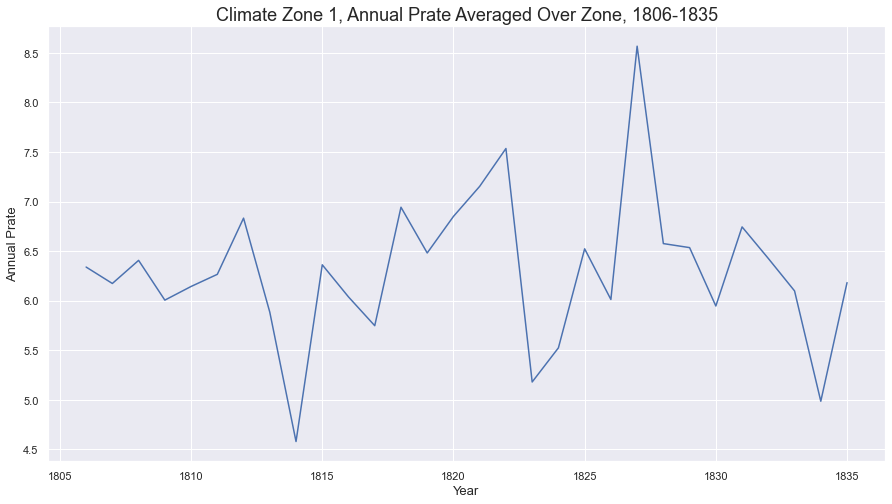

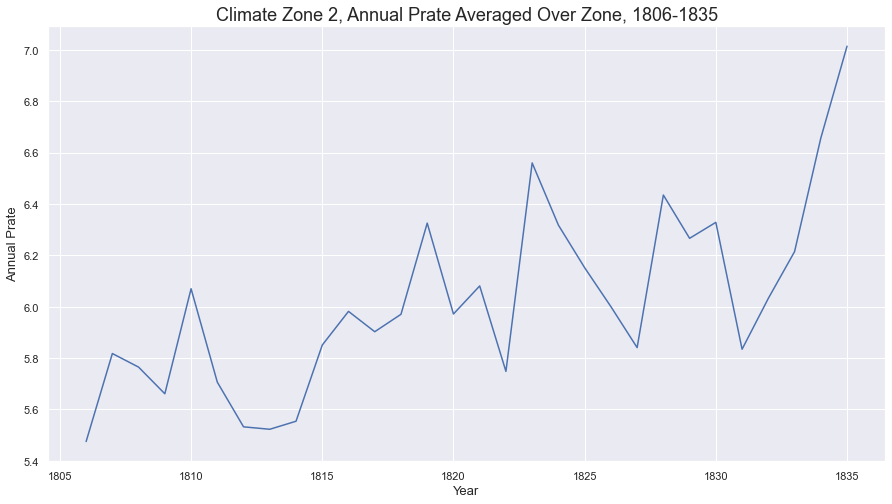

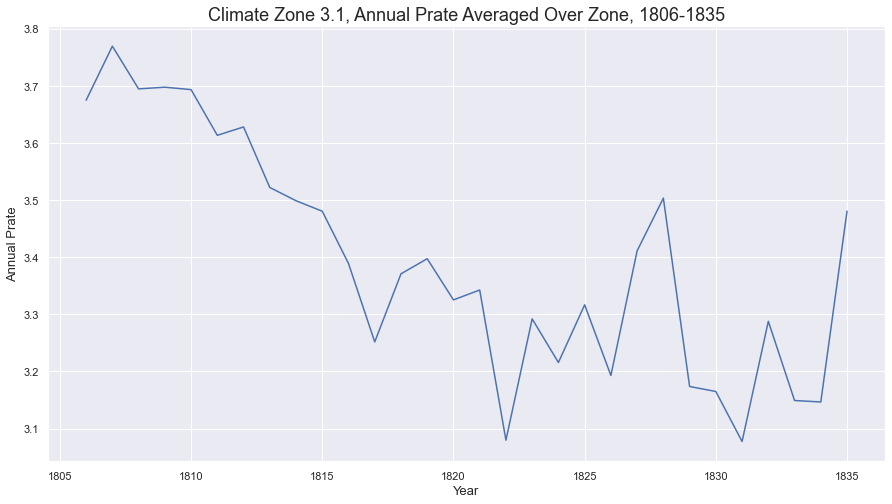

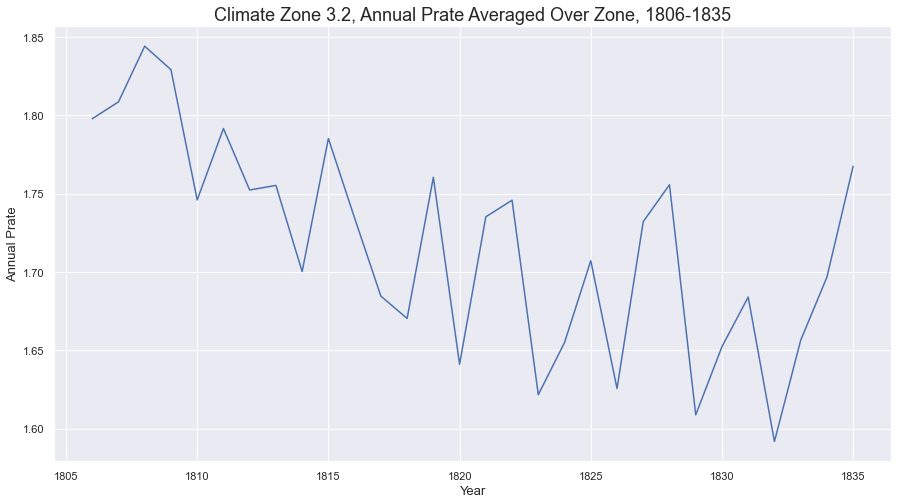

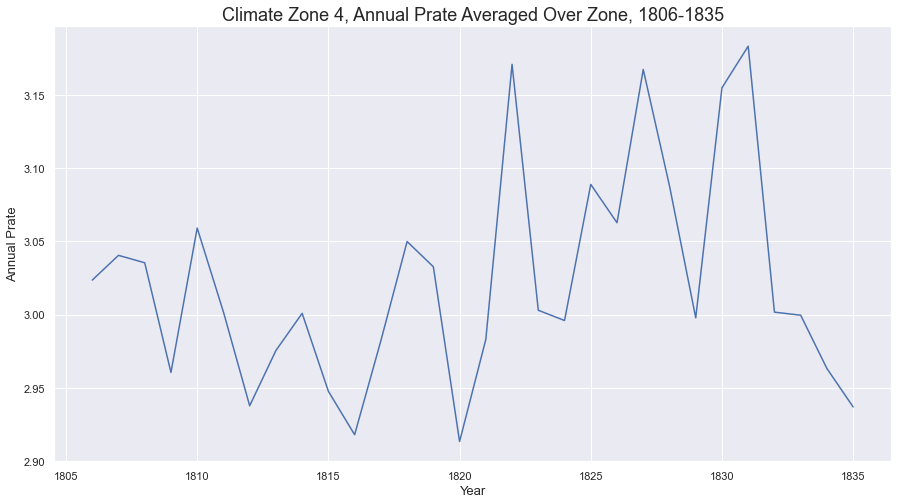

In [34]:
# plot the graphs
save_path = '/Users/Sienna/Desktop/time_series/'
os.makedirs(save_path, exist_ok=True)

for zone_i, zone in enumerate(target_zones.keys()):
    data = {
        'Year': list(range(min_year, max_year+1)),
        'Annual Prate': time_series_values[zone_i]
    }
    df = pd.DataFrame(data)
    
    sns.set(style="darkgrid")
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='Year', y='Annual Prate', data=df)

    # Customize the plot
    plt.title(f'Climate Zone {zone}, Annual Prate Averaged Over Zone, {min_year}-{max_year}', fontsize=18)
    plt.xlabel('Year', fontsize=13)
    plt.ylabel('Annual Prate', fontsize=13)

    # Save the plot to a file
    plt.savefig(f'{save_path}zone{zone}_time_series.png', format='png')

    # Show the plot
    plt.show()

# Comparison to ICOADS data

We compare years 1806-1832. A year is defined as June of current year to May of next year. So year 1832 is actually June 1832 to May 1833.

In [9]:
zones = [1, 2, 3.1, 3.2, 4]

In [10]:
min_year = 1806
max_year = 1832

years = []
for i in range(min_year, max_year+1):
    year = f'{i}-06-01'
    years.append(year)

In [11]:
# open the REAN data
rean_df = pd.read_csv("/Users/Sienna/Desktop/REAN/rean_v3_prate_wide_annual_1806_2015.csv")

# a 5-dimension list, each element is a sublist that is the time-series value 
# which is the annual_prate averageing over the zone
rean_time_series_values = []

for zone in zones:
    zone_time_series = []
    for year in years:
        cur_df = rean_df[(rean_df["Date"] == year) & (rean_df["target_zone"] == zone)]
        zone_time_series.append(cur_df['annual_prate'].mean())
    rean_time_series_values.append(zone_time_series)

In [12]:
# a 5-dimension list, each element is a sublist that is the time-series value 
# which is the rainfall percentage averageing over the zone
icoads_time_series_values = []

for zone in zones:
    icoads_df = pd.read_csv(f"/Users/Sienna/Desktop/ICOADS/zone{zone}_annual_data.csv")
    icoads_df = icoads_df[(icoads_df["year"] >= min_year) & (icoads_df["year"] <= max_year)]
    
    icoads_time_series_values.append(icoads_df["rainfall_percentage"].to_list())

Zone 1 correlation: 0.05474875257958443


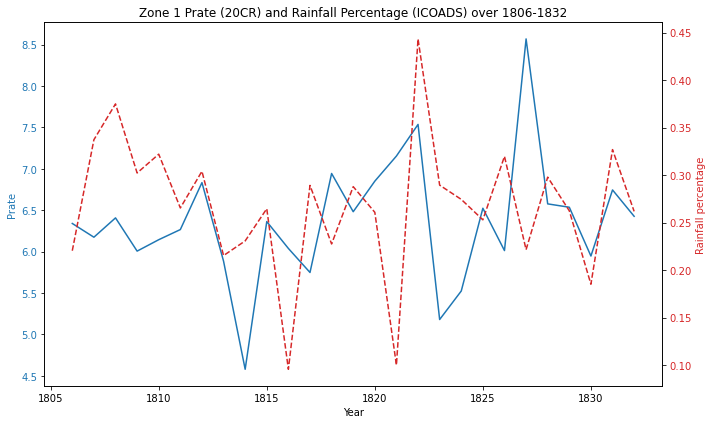

Zone 2 correlation: -0.13635793887482225


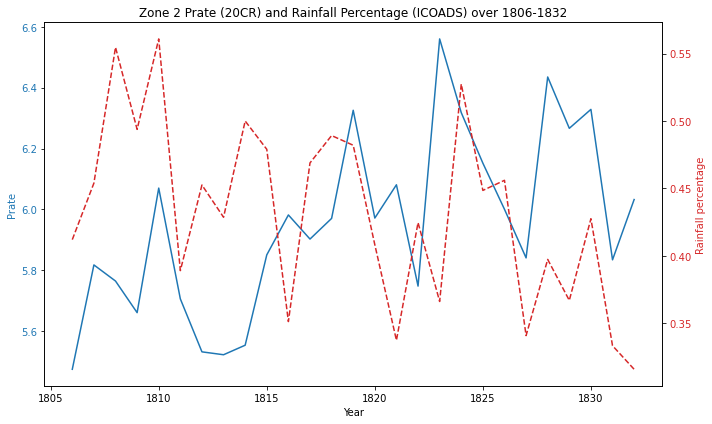

Zone 3.1 correlation: 0.2345366269971436


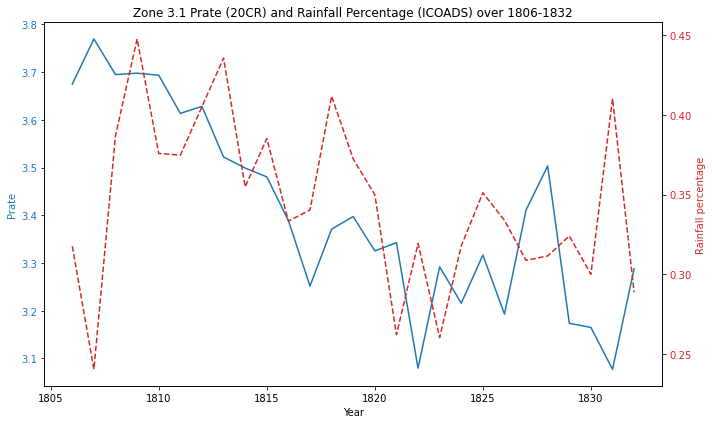

Zone 3.2 correlation: 0.18210409149134377


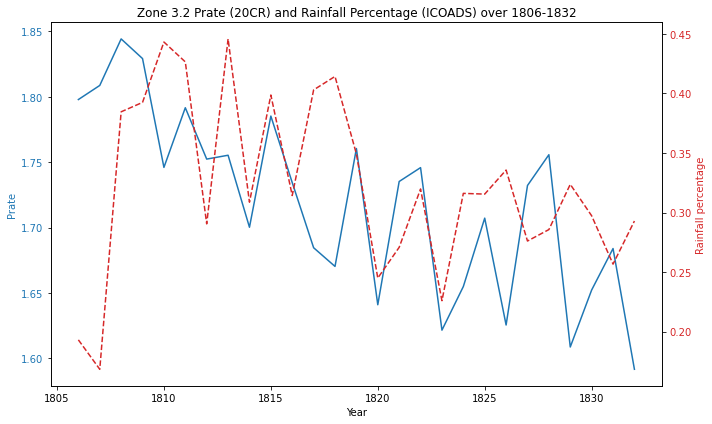

Zone 4 correlation: -0.2594849145627345


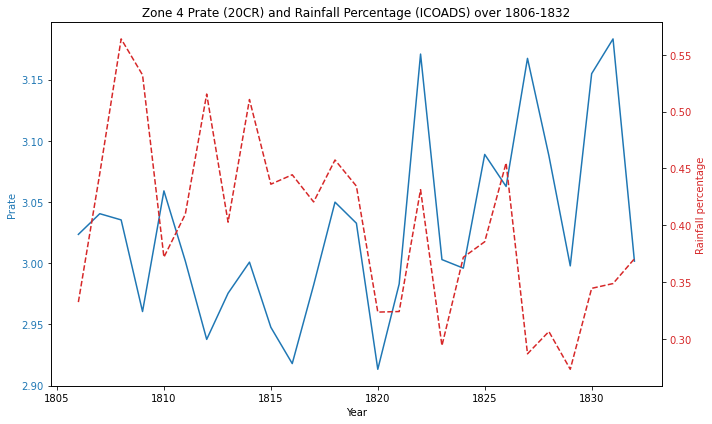

In [13]:
# let's plot and calculate correlation
plot_dir_path = f'/Users/Sienna/Desktop/ICOADS/corr_plots/'
os.makedirs(plot_dir_path, exist_ok=True)

correlation_messages = []

for zone_i, zone in enumerate(zones):
    data = {'year': range(min_year, max_year+1),
            'rean': rean_time_series_values[zone_i], 
            'icoads': icoads_time_series_values[zone_i]}
    
    cor_df = pd.DataFrame(data)
    
    # calculate correlation
    cor = cor_df['rean'].corr(cor_df['icoads'])
    cor_str = f'Zone {zone} correlation: {cor}'
    print(cor_str)
    correlation_messages.append(cor_str)
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plotting rean on the left y-axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Prate', color='tab:blue')
    ax1.plot(cor_df['year'], cor_df['rean'], label='Prate', color='tab:blue', linestyle='-')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for icoads
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Rainfall percentage', color='tab:red')  
    ax2.plot(cor_df['year'], cor_df['icoads'], label='Rainfall percentage', color='tab:red', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Title and grid
    plt.title(f'Zone {zone} Prate (20CR) and Rainfall Percentage (ICOADS) over {min_year}-{max_year}')
    fig.tight_layout()  # Adjust layout to make room for the second y-axis
    
    plt.savefig(f'{plot_dir_path}zone{zone}_corr.jpg')

    # Show plot
    plt.show()

In [14]:
for msg in correlation_messages:
    print(msg)

Zone 1 correlation: 0.05474875257958443
Zone 2 correlation: -0.13635793887482225
Zone 3.1 correlation: 0.2345366269971436
Zone 3.2 correlation: 0.18210409149134377
Zone 4 correlation: -0.2594849145627345
